In [1]:
from ngsolve.la import InnerProduct, MultiVector
from ngsolve import Matrix, Vector
import scipy.linalg
from ngsolve import *
from netgen.csg import *
import numpy as np

tol = 1e-14
it = 300

from ngsolve.la import InnerProduct, MultiVector
from ngsolve import Matrix, Vector

try:
    import scipy.linalg
    from scipy import random
except:
    pass

def lobpcg(mata, matm, pre, num=1, maxit=20, printrates=True, GramSchmidt=False):

    numIterations = 0
    r = mata.CreateRowVector()

    # using multivectors for better performance
    uvecs = MultiVector(r, num)
    vecs = MultiVector(r, 3 * num)

    for v in vecs:
        r.SetRandom()
        v.data = pre * r
    #uvecs[:] = pre * vecs[0:num]
    lams = Vector(num * [1])
    res = []

    for i in range(maxit):
        numIterations += 1

        uvecs[0:num] = mata * vecs[0:num]
        uvecs[0:num] -= (matm * vecs[0:num]).Scale(lams)

        vecs[2*num:3 * num] = pre * uvecs[0:num]

        #T-norm res
        resnorm=InnerProduct(uvecs[0],vecs[2*num])
        for j in range(1, num):
            tmp = InnerProduct(uvecs[j], vecs[2*num+j])
            #print(tmp)
            if (resnorm < tmp):
                resnorm = tmp
        res = np.append(res, resnorm)

        vecs.Orthogonalize()

        asmall = InnerProduct(vecs, mata * vecs)
        msmall = InnerProduct(vecs, matm * vecs)

        ev, evec = scipy.linalg.eigh(a=asmall, b=msmall)
        lams = Vector(ev[0:num])
        if printrates:
            print(i, ":", list(lams))

        mat = Matrix(evec[:, 0:num])
        uvecs[0:num] = vecs * mat

        #print("res:", res[i], "\n")
        if (res[i] < tol  or i >= maxit):
            print("iterationen:", i)
            break

        #use span{u^i,u^{i-1},w^i}
        vecs[num:2*num] = vecs[0:num]
        vecs[0:num] = uvecs[0:num]

    return lams, uvecs, res

def PINVITres(mata, matm, pre, num=1, maxit=20, printrates=True, GramSchmidt=True):
    """preconditioned inverse iteration"""
    import scipy.linalg

    r = mata.CreateRowVector()
    
    uvecs = MultiVector(r, num)
    vecs = MultiVector(r, 2*num)
    # hv = MultiVector(r, 2*num)

    for v in vecs:
        r.SetRandom()
        v.data = pre * r
    lams = Vector(num * [1])
    res = []
    
    for i in range(maxit):
        uvecs.data = mata * vecs[0:num] - (matm * vecs[0:num]).Scale (lams)
        vecs[num:2*num] = pre * uvecs[0:num]

        #T-norm res
        resnorm=InnerProduct(uvecs[0],vecs[num])
        for j in range(1, num):
            tmp = InnerProduct(uvecs[j], vecs[num+j])
            #print(tmp)
            if (resnorm < tmp):
                resnorm = tmp
        res = np.append(res, resnorm)

        vecs.Orthogonalize(matm)

        asmall = InnerProduct (vecs, mata * vecs)
        msmall = InnerProduct (vecs, matm * vecs)
    
        ev,evec = scipy.linalg.eigh(a=asmall, b=msmall)
        lams = Vector(ev[0:num])
        if printrates:
            print (i, ":", list(lams))

        uvecs[:] = vecs * Matrix(evec[:,0:num])
        vecs[0:num] = uvecs[0:num]

        #print("res:", res[i], "\n")
        if ((res[i] < tol and i > 0 ) or i >= maxit):
            print("iterationen:", i)
            break

    return lams, uvecs, res

In [2]:
testgeom = 4
#1=conrod
#2=crank
#3=piston
 
if testgeom == 1:
    from ngsolve import *
    from netgen.csg import *
    import numpy as np

    #parameters

    #crank:
    b1 = 0.012 #width of journal bearing
    r1 = 0.012 #radius of journal bearing
    dk = 0.015 #crank arm width (z)
    bk = 0.032 #crank arm size (y)

    l3 = 0.030
    l4 = 0.040
    #l4x= 0.005 #offset of counterweight
    lk = 0.030 #l4*0.5+l3 #crank arm length (x)
    bm = 0.065
    dBevel = dk*0.5
    #shaft:
    r0 = 0.012 #0.012
    d0 = 0.020 #shaft length at left/right support
    d1 = 0.012 #shaft length at intermediate support

    #distance rings:
    db = 0.002          #width of distance ring
    rdb0 = r0+db        #total radius of distance ring, shaft
    rdb1 = r1+db        #total radius of distance ring, crank

    #conrod:
    bc = 0.024      #height of conrod
    dc = 0.012      #width of conrod
    lc = 0.080      #length of conrod (axis-axis)
    r1o= r1+0.006   #outer radius of conrod at crank joint
    r2 = 0.008      #radius of piston journal bearing
    r2o= r2+0.006   #outer radius of conrod at piston joint

    cylOffZ=0.010  #z-offset of cylinder cut out of conrod
    cylR = 0.008    #radius of cylinder cut out of conrod

    angC = 4*np.pi/180

    #piston:
    dpb = r2o-0.000   #axis inside piston
    r2p = r2o+0.004   #0.018
    lp = 0.034
    bp = 0.050
    lpAxis = dc+2*db
    lOffCut = 0.011 #offset for cutout of big cylinder

    #total length of one segment:
    lTotal = db+dk+db+b1+db+dk+db+d1

    #eps
    eps = 5e-4 #added to faces, to avoid CSG-problems

    def RotationMatrixZ(angleRad):
        return np.array([ [np.cos(angleRad),-np.sin(angleRad), 0],
                          [np.sin(angleRad), np.cos(angleRad), 0],
                          [0,	    0,        1] ]);

    def VAdd(v0, v1):
        if len(v0) != len(v1): print("ERROR in VAdd: incompatible vectors!")
        n = len(v0)
        v = [0]*n
        for i in range(n):
            v[i] = v0[i]+v1[i]
        return v

    def VSub(v0, v1):
        if len(v0) != len(v1): print("ERROR in VSub: incompatible vectors!")
        n = len(v0)
        v = [0]*n
        for i in range(n):
            v[i] = v0[i]-v1[i]
        return v

    def NormL2(vector):
        value = 0
        for x in vector:
            value += x**2
        return value**0.5

    def Normalize(v):
        v2=[0]*len(v)

        fact = NormL2(v)
        fact = 1./fact
        for i in range(len(v2)): 
            v2[i]=fact*v[i]
        return v2

    def GenerateConrod(zOff):
        ey0 = [0,1,0] #top/bottom face vector of conrod
        ey1 = [0,-1,0]

        ex0 = [1,0,0] #top/bottom face vector of conrod
        ex1 = [1,0,0]

        ey0 = RotationMatrixZ(-angC)@ey0
        ey1 = RotationMatrixZ(angC)@ey1
        ex0 = RotationMatrixZ(-angC)@ex0
        ex1 = RotationMatrixZ(angC)@ex1


        pl1 = Plane(Pnt(0, 0.5*bc,0),Vec(ey0[0],ey0[1],ey0[2]))
        pl2 = Plane(Pnt(0,-0.5*bc,0),Vec(ey1[0],ey1[1],ey1[2]))

        pl3 = Plane(Pnt(-0.5*lc,0,0),Vec(-1,0,0))
        pl4 = Plane(Pnt( 0.5*lc,0,0),Vec( 1,0,0))

        pl5 = Plane(Pnt( 0,0,-0.5*dc+zOff),Vec( 0,0,-1))
        pl6 = Plane(Pnt( 0,0, 0.5*dc+zOff),Vec( 0,0, 1))


        cylC1 = Cylinder(Pnt(-0.5*lc,0,-1), Pnt(-0.5*lc,0,1), r1)
        #cylC1o = Cylinder(Pnt(-0.5*lc,0,-1), Pnt(-0.5*lc,0,1), r1o)
        cylC1o = Sphere(Pnt(-0.5*lc,0,zOff), r1o) #in fact is a sphere

        cylC2 = Cylinder(Pnt( 0.5*lc,0,-1), Pnt( 0.5*lc,0,1), r2)
        #cylC2o = Cylinder(Pnt(0.5*lc,0,-1), Pnt( 0.5*lc,0,1), r2o)
        cylC2o = Sphere(Pnt(0.5*lc,0,zOff), r2o) #in fact is a sphere

        cylSideA = (Cylinder(Pnt(-0.5*lc+r1o,0,cylOffZ+zOff), Pnt(0.5*lc-r2o,0,cylOffZ+zOff), cylR)*
                    Plane(Pnt(-0.5*lc+r1o-0.002,0,0),Vec(-1,0,0))*
                    Plane(Pnt( 0.5*lc-r2o+0.002,0,0),Vec( 1,0,0)))

        cylSideB = (Cylinder(Pnt(-0.5*lc+r1o,0,-cylOffZ+zOff), Pnt(0.5*lc-r2o,0,-cylOffZ+zOff), cylR)*
                    Plane(Pnt(-0.5*lc+r1o-0.002,0,0),Vec(-1,0,0))*
                    Plane(Pnt( 0.5*lc-r2o+0.002,0,0),Vec( 1,0,0)))


        return ((pl1*pl2*pl3*pl4+cylC1o+cylC2o)-cylC1-cylC2)*pl5*pl6-cylSideA-cylSideB
        #return pl1*pl2*pl3*pl4*pl5*pl6

    geoConrod = CSGeometry()
    conrod = GenerateConrod(0)#db+dk+db+0.5*b1
    geoConrod.Add(conrod)

    meshSize = 0.0075
    mesh = Mesh( geoConrod.GenerateMesh(maxh=meshSize+0.001*0))
    Draw(mesh)

In [3]:
if testgeom == 4:
    cube = OrthoBrick( Pnt(0,0,0), Pnt(1,1,1) )
    geo = CSGeometry()
    geo.Add (cube)
    ngmesh = geo.GenerateMesh(maxh=0.075)
    mesh = Mesh(ngmesh)

In [4]:
meshOrder = 2
elOrder = 2
if meshOrder == 2:
    mesh.ngmesh.SecondOrder()
Draw(mesh)

In [5]:
fes = VectorH1(mesh, order=elOrder)
u = fes.TrialFunction()
v = fes.TestFunction()
bfK = BilinearForm(fes)
bfM = BilinearForm(fes)

In [6]:
def sigma(eps, mu, lam):
    return 2*mu*eps + lam*Trace(eps) * Id(eps.dims[0])

#für crankshaft
density = 7850
youngsModulus = 2.1e11 *1e-1
poissonsRatio = 0.3

#density = 1
#youngsModulus = 1e13
#poissonsRatio = 1

E = youngsModulus
nu = poissonsRatio
rho = density

mu  = E / 2 / (1+nu) #Lame parameters
lam = E * nu / ((1+nu)*(1-2*nu))

bfK += InnerProduct(sigma(Sym(Grad(u)),mu,lam), Sym(Grad(v)))*dx
#bfK += InnerProduct(grad(u), grad(v))*dx
bfM += rho*u*v * dx

bfK.Assemble()
bfM.Assemble()

In [7]:
ndscal = fes.ndof // mesh.dim
nv = mesh.nv

fes.SetCouplingType(IntRange(0, fes.ndof), COUPLING_TYPE.INTERFACE_DOF)
fes.SetCouplingType(IntRange(0, nv), COUPLING_TYPE.WIREBASKET_DOF)
fes.SetCouplingType(IntRange(ndscal, ndscal + nv), COUPLING_TYPE.WIREBASKET_DOF)
fes.SetCouplingType(IntRange(2*ndscal, 2*ndscal + nv), COUPLING_TYPE.WIREBASKET_DOF)

F = specialcf.JacobianMatrix(3)
cond = Norm(F) * Norm(Inv(F))
ir = IntegrationRule([(1/4,1/4,1/4)], [1])

for el in mesh.Elements(VOL):
    trafo = mesh.GetTrafo(el)
    mir = trafo(ir)
    condT = max(cond(mir))
    if condT > 8:
        for i in fes.GetDofNrs(el):
            fes.SetCouplingType(i, COUPLING_TYPE.WIREBASKET_DOF)
        print (condT)

with TaskManager():
    bfKbddc = BilinearForm(fes, eliminate_internal=True)
    bfKbddc += InnerProduct(sigma(Sym(Grad(u)), mu, lam), Sym(Grad(v))) *dx
    bfKbddc += 1e6*rho*u*v *dx
    prebddc = Preconditioner(bfKbddc, "bddc")
    bfKbddc.Assemble()

[8.47198817]
[8.52193252]
[8.13331117]
[8.86303476]
[8.39802667]
[9.32920191]
[8.44489186]
[8.733714]
[8.28226619]
[8.90365555]
[8.00585796]
[8.41673212]
[8.12961538]
[8.71598712]
[8.30995035]


In [8]:
lams, evecs, reslop = lobpcg(bfK.mat, bfM.mat, prebddc, num=1, maxit=it, printrates=False, GramSchmidt=True)

res: 0.18370563631155157 

res: 181605892.01738158 

res: 52364625.62151679 

res: 15940991.19116045 

res: 6530553.639852625 

res: 2681515.792145672 

res: 1225546.3686529542 

res: 567813.9746843742 

res: 280037.03144473105 

res: 149826.39429074683 

res: 92900.74313431038 

res: 55925.74411899541 

res: 34760.70445811001 

res: 21989.02655085812 

res: 14015.402660830914 

res: 8692.623093274757 

res: 5448.066700105656 

res: 3238.173065340429 

res: 1892.1057113618808 

res: 1070.1819458991995 

res: 636.4580902656513 

res: 346.22157166640335 

res: 213.48060754306314 

res: 139.76069532541473 

res: 86.56167662595232 

res: 53.30837937652733 

res: 29.704684646695775 

res: 18.262004227990328 

res: 11.805834091965579 

res: 7.790455401555152 

res: 4.237562468395366 

res: 2.470217206690811 

res: 1.471479080470124 

res: 0.9101029529446414 

res: 0.5321525485902844 

res: 0.3208922077271118 

res: 0.1987469170025064 

res: 0.13269004294437942 

res: 0.07044726094614188 

re

In [9]:
from ngsolve.eigenvalues import PINVIT
lams,evecs, respinv = PINVITres(bfK.mat, bfM.mat, prebddc, num=1, maxit=it, printrates=False, GramSchmidt=True)

In [10]:
print(reslop)
print(respinv)

[1.83705636e-01 1.81605892e+08 5.23646256e+07 1.59409912e+07
 6.53055364e+06 2.68151579e+06 1.22554637e+06 5.67813975e+05
 2.80037031e+05 1.49826394e+05 9.29007431e+04 5.59257441e+04
 3.47607045e+04 2.19890266e+04 1.40154027e+04 8.69262309e+03
 5.44806670e+03 3.23817307e+03 1.89210571e+03 1.07018195e+03
 6.36458090e+02 3.46221572e+02 2.13480608e+02 1.39760695e+02
 8.65616766e+01 5.33083794e+01 2.97046846e+01 1.82620042e+01
 1.18058341e+01 7.79045540e+00 4.23756247e+00 2.47021721e+00
 1.47147908e+00 9.10102953e-01 5.32152549e-01 3.20892208e-01
 1.98746917e-01 1.32690043e-01 7.04472609e-02 4.07906600e-02
 2.50945211e-02 1.77664206e-02 1.00908766e-02 5.69612629e-03
 3.61469514e-03 2.09997823e-03 1.28113650e-03 7.80522299e-04
 5.13242968e-04 2.93885902e-04 1.80046554e-04 1.00760123e-04
 6.34541164e-05 4.03953131e-05 2.54021732e-05 1.58175741e-05
 8.24926902e-06 5.22404155e-06 3.12149012e-06 2.05815466e-06
 1.26073972e-06 7.35362776e-07 4.07308044e-07 2.47245975e-07
 1.71348099e-07 9.805029

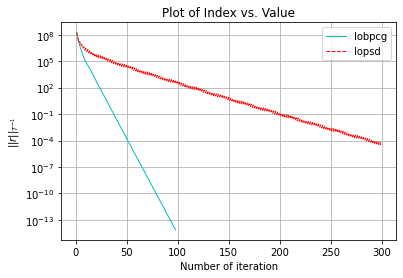

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x-axis values based on array length
x = np.arange(1,len(respinv)+1)

# Plotting the array
plt.semilogy(list(range(1,len(reslop))),reslop[1:len(reslop)],color="c",linestyle="-",linewidth=1,label="lobpcg")
plt.semilogy(list(range(1,len(respinv))),respinv[1:len(respinv)],color="r",linestyle="--",linewidth=1,label="lopsd")
plt.xlabel('Number of iteration')
plt.ylabel(r'$||r||_{T^{-1}}$')
plt.title('Plot of Index vs. Value')
plt.grid(True)
plt.legend()
plt.show()

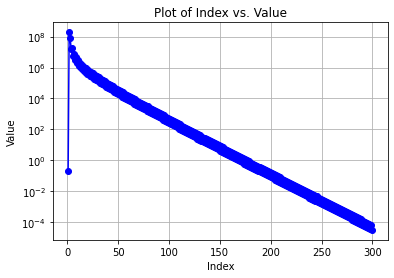

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x-axis values based on array length
x = np.arange(1,len(respinv)+1)

# Plotting the array
plt.semilogy(x, respinv, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of Index vs. Value')
plt.grid(True)
plt.show()